In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import optuna
import xgboost as xgb
import warnings
from tqdm.notebook import tqdm

In [50]:
label = LabelEncoder()
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [52]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [54]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [55]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: xlabel='isFraud', ylabel='count'>

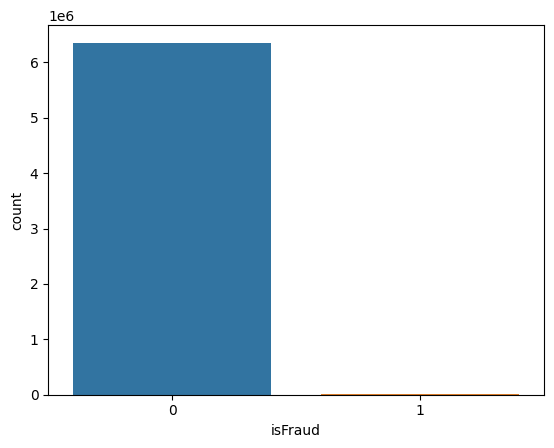

In [56]:
sns.countplot(x = df['isFraud'])

As we can see the variable that we are targetting is imbalanced.

<Axes: >

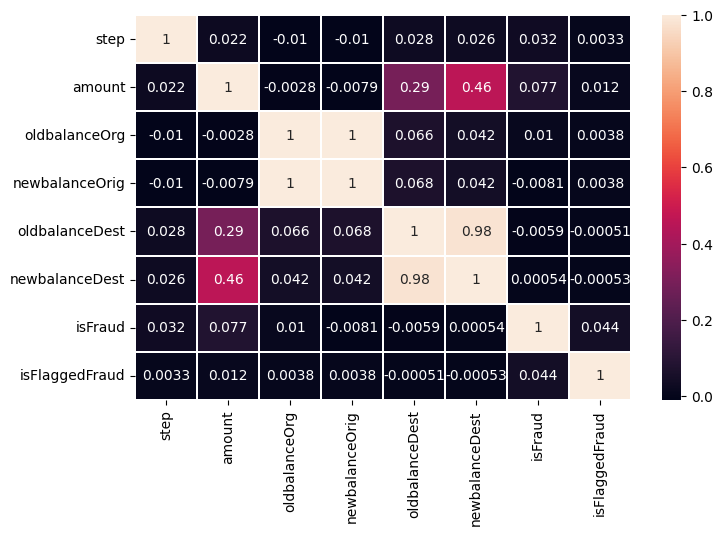

In [57]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=0.3)

In [58]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [59]:
fraud = df[df['isFraud'] == 1]

In [60]:
numerical_data = [i for i in df.drop('isFraud',axis=1).columns if df[i].dtypes != '0']
categorical_data = [i for i in df.drop('isFraud',axis=1).columns if df[i].dtypes == '0']
print(f'After dividing the dataset into numerical and categorical data. \nThe numerical data is : {numerical_data} \nand categorical data is : {categorical_data}')

After dividing the dataset into numerical and categorical data. 
The numerical data is : ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'] 
and categorical data is : []


In [61]:
x = df['nameOrig'].nunique() , df['nameDest'].nunique()
x

(6353307, 2722362)

<Axes: xlabel='amount', ylabel='Density'>

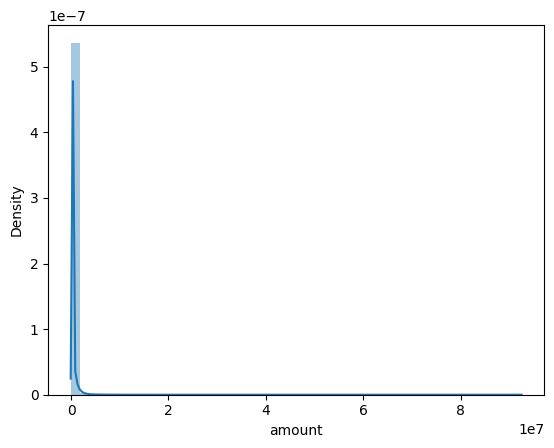

In [62]:
sns.distplot(df['amount'])

<Axes: xlabel='step', ylabel='Density'>

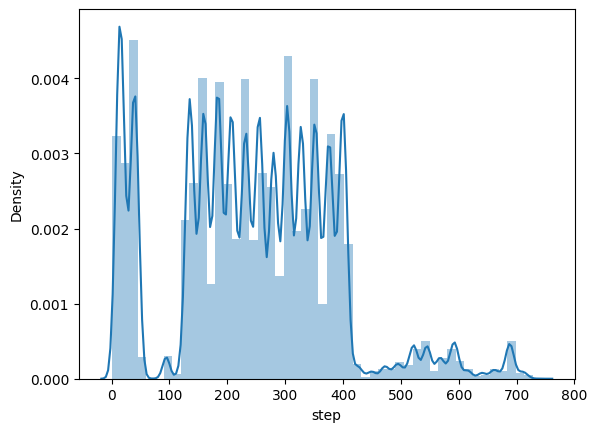

In [63]:
sns.distplot(df['step'])

<Axes: xlabel='amount', ylabel='Density'>

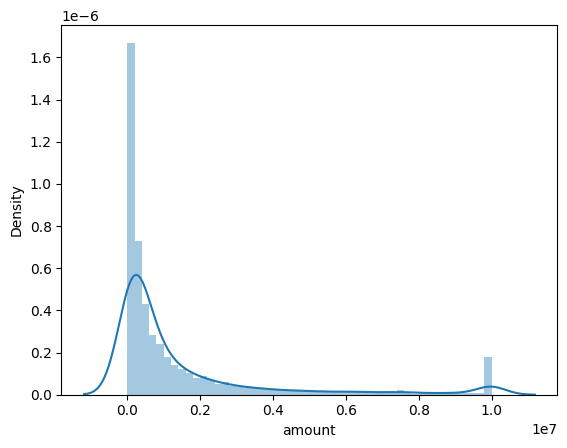

In [64]:
sns.distplot(fraud['amount'])

##### lower the amount, higher the fraud

In [65]:
fraud_data = len(df[df.isFraud == 1])
legit_data = len(df[df.isFraud == 0])

fraud_data_percentage = 100* fraud_data/(fraud_data + legit_data)
legit_data_percentage = 100* legit_data/(fraud_data + legit_data)

print(f'Fraud data percentage : {fraud_data_percentage}% and legit data percentage : {legit_data_percentage}%')

Fraud data percentage : 0.12908204481801522% and legit data percentage : 99.87091795518198%


In [66]:
Fraud = df[df.isFraud == 1]
Legit = df[df.isFraud == 0]
Fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [67]:
Fraud['newbalanceDest'].value_counts()

newbalanceDest
0.00           4091
10000000.00      53
1064995.85        2
127905.82         2
1165187.89        2
               ... 
3098931.52        1
143526.32         1
1532241.85        1
495991.64         1
7360101.63        1
Name: count, Length: 4067, dtype: int64

In [68]:
types = pd.get_dummies(df['type'], prefix='type', drop_first=True)
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,False,False,True,False
1,False,False,True,False
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False


In [69]:
fraud_new_des_data = len(Fraud[Fraud.newbalanceDest == 0.00])
100*(fraud_new_des_data/fraud_data)

49.811274808230856

In [70]:
df['nameDest'] = label.fit_transform(df['nameDest'])
df['nameOrig'] = label.fit_transform(df['nameOrig'])
df[['nameOrig','nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [71]:
Legit['newbalanceDest'].value_counts()

newbalanceDest
0.00           2435342
971418.91           32
19169204.93         29
16532032.16         25
1254956.07          25
                ...   
199687.19            1
1011484.91           1
748082.74            1
1697578.22           1
190610.24            1
Name: count, Length: 3552702, dtype: int64

In [72]:
legit_new_des_data = len(Legit[Legit.newbalanceDest == 0.00])
100*(legit_new_des_data/legit_data)

38.3252441966654

In [73]:
legit_new_data = len(Legit[Legit.newbalanceOrig == 0.00])
100*(legit_new_data/legit_data)

56.6774051457516

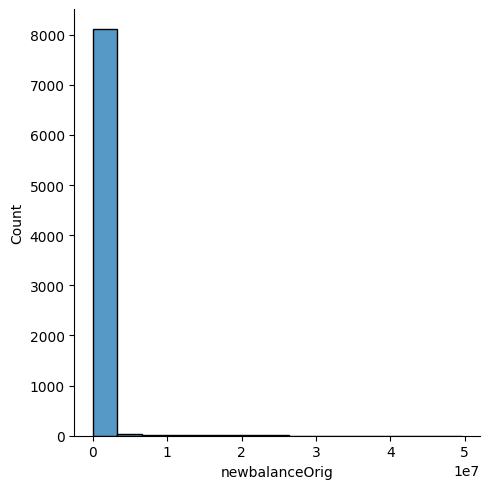

In [74]:
data = Fraud.newbalanceOrig
sns.displot(data)

<Axes: xlabel='isFraud', ylabel='oldbalanceDest'>

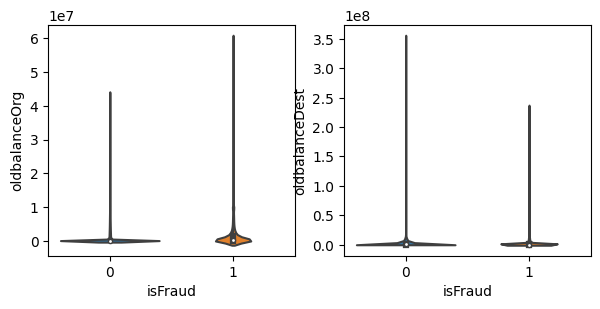

In [75]:
fig,ax=plt.subplots(1,2,figsize=(7,3))
sns.violinplot(x=df.isFraud,y=df['oldbalanceOrg'],ax=ax[0])
sns.violinplot(x=df.isFraud,y=df['oldbalanceDest'],ax=ax[1])

From above two graph we can see for both fraud and non-fraud most of the values lies tends to 0

In [76]:
fraud_new_data = len(Fraud[Fraud.newbalanceOrig == 0.00])
100*(fraud_new_data/fraud_data)

98.05186898818945

In [77]:
df = pd.concat([df,types],axis=1)
df = df.drop('type',axis=1)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,False,False,True,False
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,False,False,False,True
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,False,False,True,False


In [78]:
x = df.drop('isFraud', axis=1)
y = df['isFraud']
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=24)
splits = 2
xgpred = []
prob = []

folds = StratifiedKFold(n_splits=splits, shuffle=True)
for fold, (train_id,test_id) in enumerate(tqdm(folds.split(x,y), total=splits)):
    print(f'fold {fold + 1}')
    x_train, y_train = x.iloc[train_id],y.iloc[train_id]
    x_valid, y_valid = x.iloc[test_id],y.iloc[test_id]

    xgmodel = xgb.XGBClassifier()
    xgmodel.fit(x_train,y_train)

    print(f'Accuracy in training : {(xgmodel.score(x_train, y_train)*100).round(2)}%')
    print(f'Accuracy in validation : {(xgmodel.score(x_valid, y_valid)*100).round(2)}%')
    prob1 = xgmodel.predict_proba(x_test)
    prob.append(prob1)
print("Model Trained !!!")

  0%|          | 0/2 [00:00<?, ?it/s]

fold 1
Accuracy in training : 99.99%
Accuracy in validation : 99.98%
fold 2
Accuracy in training : 99.99%
Accuracy in validation : 99.98%
Model Trained !!!


In [79]:
f = [[0,0]]
for i in range(splits):
    f = f + prob[i]

f = f/splits
y_pred = pd.Series([np.argmax([i]) for i in f])

In [80]:
score = accuracy_score(y_test,y_pred)*100
print(f'Test Accuracy : {score}%')

Test Accuracy : 99.97988250123376%


In [81]:
cf_matrix = confusion_matrix(y_test,y_pred)
cf_matrix

array([[1270898,      19],
       [    237,    1370]])

<Axes: >

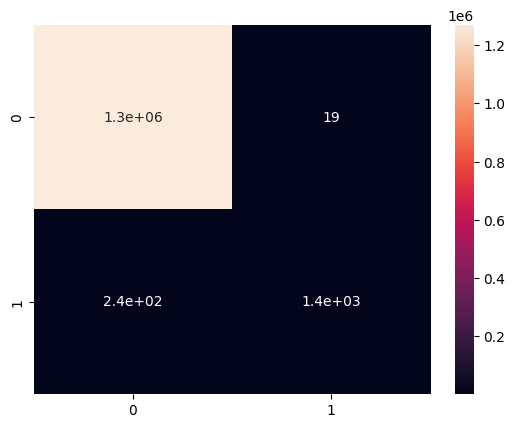

In [82]:
sns.heatmap(cf_matrix,annot=True)

In [83]:
f1 = f1_score(y_test,y_pred, average='macro')
print(f'F1 Score is : {f1}')

F1 Score is : 0.9572260154694323


## Answer to Questions

##### 1. Data cleaning including missing values, outliers and multi-collinearity.
Since there were no missing values in the dataset, I did not need to perform any data cleaning related to that. I checked for collinearity using correlation analysis. After that I directly went for model training and prediction

#### 2. Describe your fraud detection model in elaboration.
The model is based on XGBoost as it is a large and heavily imbalanced dataset. XGBoost is a gradient boosting based on decision tree algorithm, hence it was the most ideal choice for the above dataset. It is a highly robust and efficient algorithm

#### 3. How did you select variables to be included in the model?
The variables were selected on the basis of feature analysis and pre-required knowledge.

#### 4. Demonstrate the performance of the model by using best set of tools.
I validated the model on the basis of cross validation where separate test and training data was made. The model is evaluated on the basis of accuracy and f1 score.

#### 5. What are the key factors that predict fraudulent customer?
Some of the key factors that predict fraudulent customers include transaction amount, flag and type of transaction.

#### 6. Do these factors make sense? If yes, How? If not, How not?
These factors make sense because they are consistent with known patterns of fraudulent activity

#### 7. What kind of prevention should be adopted while company update its infrastructure?
To prevent fraud companies can used authenticators, detect flags and monitoring of accounts.

#### 8. Assuming these actions have been implemented, how would you determine if they work?
It can be determined by the effectiveness of the prevention measures by monitoring the number of flagged transactions and the number of false positives generated by the model. We can also evaluate the cost and efficiency of implementing the prevention measures to ensure that they are effective and feasible for the company.